# Import function of interest

In [3]:
import os
os.environ["KERAS_BACKEND"] = "plaidml.keras.backend"

import pandas as pd
import numpy as np
from tqdm import tqdm
import itertools

import matplotlib.pyplot as plt  # Pour l'affichage d'images
from matplotlib import cm # Pour importer de nouvelles cartes de couleur

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestClassifier # Pour instancier et entraîner un modèle Random Forest
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from sklearn import metrics

from PIL import Image

import tensorflow as tf
import keras
from keras.applications import VGG19
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, GlobalAveragePooling2D, Dropout, Conv2D, MaxPooling2D, BatchNormalization, LeakyReLU, Flatten
from keras.models import Model, Sequential, load_model
from keras import callbacks

%matplotlib inline

# Set path(s) :

In [4]:
csv_5fam = "/Users/Adrien/DataScientist/projet_Mushroom/reduced_dataset_5_families.csv"

### Load data:

In [5]:
df = pd.read_csv(csv_5fam)

df.head()

,image_id,image_url,family,filepath,label
0,28,http://mushroomobserver.org/images/320/28,Inocybaceae,/Users/Adrien/DataScientist/projet_Mushroom/im...,0
1,86,http://mushroomobserver.org/images/320/86,Physalacriaceae,/Users/Adrien/DataScientist/projet_Mushroom/im...,3
2,87,http://mushroomobserver.org/images/320/87,Physalacriaceae,/Users/Adrien/DataScientist/projet_Mushroom/im...,3
3,126,http://mushroomobserver.org/images/320/126,Omphalotaceae,/Users/Adrien/DataScientist/projet_Mushroom/im...,1
4,128,http://mushroomobserver.org/images/320/128,Omphalotaceae,/Users/Adrien/DataScientist/projet_Mushroom/im...,1


### Split data :

In [6]:
df2 = df.drop(['image_id', 'image_url'], axis=1)
data_train, data_test = train_test_split(df2, test_size=0.2, random_state=123)
data_train.head()

,family,filepath,label
3946,Fomitopsidaceae,/Users/Adrien/DataScientist/projet_Mushroom/im...,2
12669,Omphalotaceae,/Users/Adrien/DataScientist/projet_Mushroom/im...,1
8382,Omphalotaceae,/Users/Adrien/DataScientist/projet_Mushroom/im...,1
12482,Omphalotaceae,/Users/Adrien/DataScientist/projet_Mushroom/im...,1
4201,Physalacriaceae,/Users/Adrien/DataScientist/projet_Mushroom/im...,3


### Define the ImageDataGenerator

In [7]:
from tensorflow.keras.applications.vgg19 import preprocess_input
#from efficientnet.keras import preprocess_input

train_data_generator = ImageDataGenerator(preprocessing_function=preprocess_input,
                                          rotation_range=10,
                                          width_shift_range = 0.1,
                                          height_shift_range = 0.1,
                                          zoom_range = 1.1,
                                          horizontal_flip = True)

test_data_generator = ImageDataGenerator(preprocessing_function=preprocess_input)

## Prepare image

In [8]:
batch_size = 64

data_train["label"] = data_train["label"].astype(str)
data_test["label"] = data_test["label"].astype(str)

train_generator = train_data_generator.flow_from_dataframe(dataframe = data_train, directory="", x_col = "filepath", y_col="label", target_size=(256,256), batch_size=batch_size, class_mode='sparse')
test_generator = test_data_generator.flow_from_dataframe(dataframe = data_test, directory="", x_col = "filepath", y_col="label", target_size=(256,256), batch_size=batch_size, class_mode='sparse')


/Users/Adrien/opt/anaconda3/envs/transfer_learning_GPU/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/Adrien/opt/anaconda3/envs/transfer_learning_GPU/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Found 13709 validated image filenames belonging to 5 classes.
Found 3428 validated image filenames belonging to 5 classes.


### Load VGG19 pretrained model and freeze layers

In [9]:
vgg19 = VGG19(include_top=False, input_shape=(256, 256, 3))
for layer in vgg19.layers:
    layer.trainable = False

#vgg19.summary()

INFO:plaidml:Opening device "metal_amd_radeon_pro_5500m.0"


### Define the training model : (sequential)

In [10]:
model_vgg19 = Sequential()
model_vgg19.add(vgg19)
model_vgg19.add(GlobalAveragePooling2D())
model_vgg19.add(Dense(units = 1024, activation = 'relu'))
model_vgg19.add(Dropout(0.3))
model_vgg19.add(Dense(units = 512, activation = 'relu'))
model_vgg19.add(Dropout(0.5))
model_vgg19.add(Dense(units = 5, activation = 'softmax'))

#model_vgg19.summary()

### Compile and train the model

In [12]:
optimizer = keras.optimizers.Adam(lr=0.0001)
model_vgg19.compile(optimizer = optimizer, loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])

history_vgg19 = model_vgg19.fit_generator(generator=train_generator, 
                                epochs = 60,
                                steps_per_epoch = len(data_train)//batch_size,
                                validation_data = test_generator,
                                validation_steps = len(data_test)//batch_size)

Epoch 1/60
214/214 [==============================] - 762s 4s/step - loss: 2.3261 - acc: 0.2635 - val_loss: 1.2734 - val_acc: 0.4708
Epoch 2/60
214/214 [==============================] - 788s 4s/step - loss: 1.6120 - acc: 0.3079 - val_loss: 1.2165 - val_acc: 0.4944
Epoch 3/60
214/214 [==============================] - 796s 4s/step - loss: 1.5020 - acc: 0.3391 - val_loss: 1.1772 - val_acc: 0.5244
Epoch 4/60
214/214 [==============================] - 779s 4s/step - loss: 1.4517 - acc: 0.3623 - val_loss: 1.1391 - val_acc: 0.5342
Epoch 5/60
214/214 [==============================] - 783s 4s/step - loss: 1.4176 - acc: 0.3827 - val_loss: 1.1181 - val_acc: 0.5419
Epoch 6/60
214/214 [==============================] - 777s 4s/step - loss: 1.4020 - acc: 0.3888 - val_loss: 1.1025 - val_acc: 0.5464
Epoch 7/60
214/214 [==============================] - 776s 4s/step - loss: 1.3809 - acc: 0.4031 - val_loss: 1.1005 - val_acc: 0.5550
Epoch 8/60
214/214 [==============================] - 769s 4s/step - 

## Plot the training history

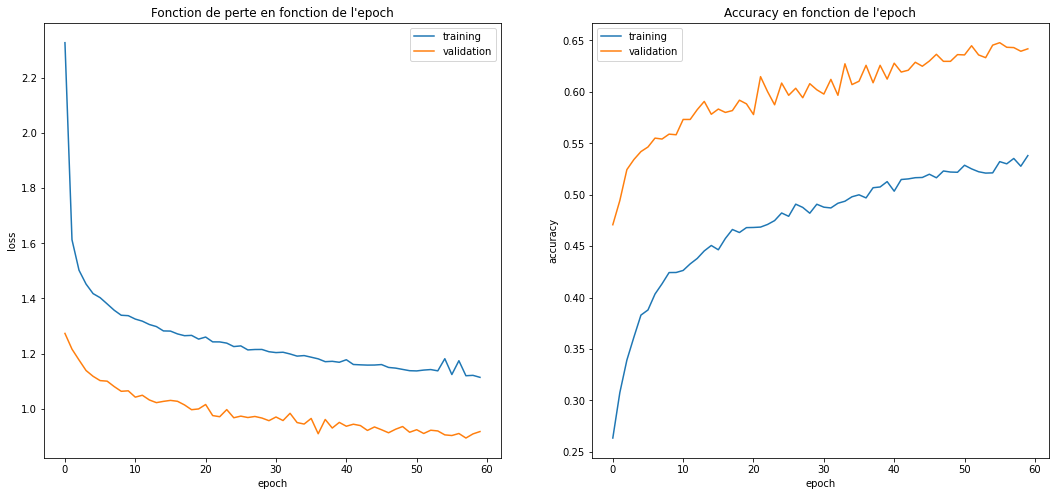

In [13]:
plt.figure(figsize=(18,8))
plt.subplot(121)
plt.plot(range(len(history_vgg19.history['loss'])), history_vgg19.history['loss'], label = "training")
plt.plot(range(len(history_vgg19.history['val_loss'])), history_vgg19.history['val_loss'], label = "validation")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.title("Fonction de perte en fonction de l'epoch")
plt.legend()

plt.subplot(122)
plt.plot(range(len(history_vgg19.history['acc'])), history_vgg19.history['acc'], label = "training")
plt.plot(range(len(history_vgg19.history['val_acc'])), history_vgg19.history['val_acc'], label = "validation")
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.title("Accuracy en fonction de l'epoch")
plt.legend();

### Sauvegarder le modèle :

- permet de continuer l'entrainement...
- reloader pour faire des prédictions plus tard...

In [14]:
### Set the path and name you want !
##
#
save_name = "/Users/Adrien/DataScientist/projet_Mushroom/models_GPU_20210620/model_vgg19_GPU_20210620.h5"
#
##
###


model_vgg19.save(save_name)